# Perceptrón de Hinton
### Descripción General del Práctico
En este práctico, exploraremos la implementación y el entrenamiento de un modelo Perceptrón de Hinton para generación de imágenes. Usaremos los datasets [MNIST](https://es.wikipedia.org/wiki/Base_de_datos_MNIST) y [FashionMNIST](https://en.wikipedia.org/wiki/Fashion_MNIST).

### Objetivo del Práctico
El objetivo de este práctico es endender cómo se implementa y entrena el Perceptrón presentado por Hinton para generación de imágenes.

### Imports

In [1]:
import time
import math
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

### Seteo de Device

Seteamos sobre que dispositivo vamos a estar corriendo el entrenamiento e inferencia.

In [2]:
DEVICE = torch.device(
    'cuda:0' if torch.cuda.is_available() else 
    'mps' if torch.backends.mps.is_available() else 
    'cpu'
)
print(DEVICE)

#torch.manual_seed(42)
#torch.backends.cudnn.deterministic = True

cpu


### Transformaciones:

Creamos la transformación para binarizar nuestro dataset. Esto va a hacer que pasemos de $[0, 256]$ a $\{0, 1\}$. A su vez agregamos la transformación trabajar con tensores.

In [3]:
class BinarizedTransform:
    def __call__(self, img):
        return (img > .5).float()
    
    
img_transforms = transforms.Compose([transforms.ToTensor(), BinarizedTransform()])
#img_transforms = transforms.Compose([transforms.ToTensor()])
img_shape = (28,28)
img_size = 28*28*1
num_classes = 10

### Dataset

Vamos a estar trabajando con el dataset de [MNIST](https://es.wikipedia.org/wiki/Base_de_datos_MNIST) que nos brinda imágenes de 28*28 de dígitos escritos a mano.

Para la generación vamos a estar trabajando únicamente con un solo dígito. Vamos a setearlo en este momento y continuamos trabajando con este.

In [4]:
labels_used = [8]

### Carga de datos y creación de Dataloader.

In [5]:
BATCH_SIZE = 64

download_dataset = False # If you already have the dataset you could use False

train_data = datasets.MNIST(root='mnist/', train=True, transform=img_transforms, download=download_dataset)
train_data = [(image, label) for image, label in train_data if labels_used and label in labels_used]

train_dataloader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True
)


### Exploración del Dataset

In [6]:
def show_images(images, title="MNIST Images"):
    n = len(images)
    rows = math.floor(math.sqrt(n))
    columns = math.ceil(n / rows)

    fig, axs = plt.subplots(rows, columns)
    fig.suptitle(title, fontsize=14, y=.95)

    for i in range(rows):
        for j in range(columns):
            index = i*columns + j
            if index < n:
                axs[i,j].imshow(images[index], cmap='gray')
            axs[i,j].axis('off')

    plt.show()

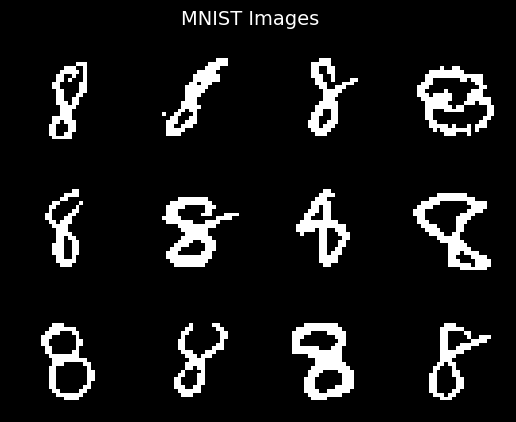

In [7]:
images = []
for _ in range(12):
    image, label = train_data[random.randrange(len(train_data))]
    images.append(image.reshape(img_shape))
show_images(images)

### Definicion de Hinton Perceptron

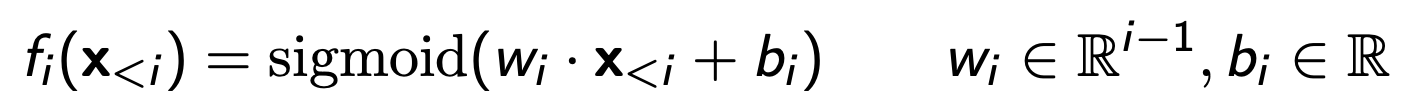

Para replicar esto usaremos una máscara que deje a todos los pesos que "ven el futuro" no afecten la predicción.
Revisar [torch.tril](https://docs.pytorch.org/docs/stable/generated/torch.tril.html). No se olviden de la diagonal!

In [8]:
ones = torch.ones((3,3))

masked_ones = torch.tril(ones, diagonal=-1) # Usar torch.tril para crear una mascara triangular inferior
print(masked_ones.T)
print(torch.matmul(ones, masked_ones.T))

tensor([[0., 1., 1.],
        [0., 0., 1.],
        [0., 0., 0.]])
tensor([[0., 1., 2.],
        [0., 1., 2.],
        [0., 1., 2.]])


¿Qué resultado debería dara la multiplicación de ones . masked_ones.T?

Nos da otra matriz de 3x3 en la que todos los valores de la columna i (entre 0 y 2) tienen el valor i

Recomendamos usar [nn.Parameter](https://docs.pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) para la definición de los pesos y del bias.

In [78]:
class HintonPerceptron(nn.Module):
    def __init__(
        self,
        input_size: int,
        img_shape: tuple[int, int]
    ):
        super(HintonPerceptron, self).__init__()
        self.img_shape = img_shape
        self.img_size = torch.prod(torch.tensor(img_shape)).item()

        # Inicializamos pesos W
        self.w = nn.Parameter(
            torch.randn((input_size, input_size)) * 0.01)

        # Guardamos la máscara
        self.mask = torch.tril(torch.ones((input_size, input_size)), diagonal=-1).to(DEVICE)

        # Inicializamos bias b
        self.bias = nn.Parameter(torch.zeros(input_size))
        
    def forward(
        self,
        x: torch.Tensor
    ):
        # Aplicamos la máscara a w para no usar pesos futuros
        w_masked = self.w * self.mask

        # Multiplicamos x . w^T (w transpuesta)
        x_w = x.matmul(w_masked.T)

        # Sumamos el bias
        logits = x_w + self.bias
        
        # Aplicamos la función de activación y retornamos
        return torch.sigmoid(logits)
    
    def generate_x(
        self,
        num_images: int
    ):
        # Usamos torch.no_grad() porque no necesitamos gradientes para generar imágenes
        with torch.no_grad():
            
            # Inicializamos las imágenes con ceros
            x = torch.zeros((num_images, self.img_size)).to(DEVICE)
            # Generamos imágenes de tamaño num_images x img_size
            # Para cada píxel
            for i in range(self.img_size):
                p = self.forward(x) 
                #x = self.forward(x)
                for j in range(num_images):
                    #print(f"probabilidad: imagen {j}, pixel {i}: ", x[j, i])
                    pixel = torch.bernoulli(p[j, i])  # Muestreamos una distribución Bernoulli
                    #pixel = torch.bernoulli(x[j, i])
                    x[j, i] = pixel
            x = x.reshape((num_images, *self.img_shape))


            return x.cpu()

### Creación del modelo y seteo de Hyper-parámetros
En esta sección del código, se crea el modelo.

Y se eligen arbitrariamente los siguientes hyper-parámetros:
- learning rate (lr)
- cantidad de épocas (epochs)
- optimizador (optim)

In [85]:
lr = 0.01 # Probamos nosotros
epochs = 30 # Probamos nosotros
criterion = nn.BCELoss # función de pérdida, (vamos a usar BCE)

model = HintonPerceptron(
    input_size=img_size,
    img_shape=img_shape
).to(DEVICE)

In [86]:
optim_1 = optim.Adam(model.parameters(), lr=lr)

¿Por qué eligió usar esa función de pérdida?

Usamos Binary Cross-Entropy porque estamos en un problema de clasificación binaria. Esta función compara la probabilidad predicha con la etiqueta real y penaliza más fuerte los errores grandes.
Las salidas de la red corresponden a la probabilidad de que un pixel sea 1, y se comparan contra el valor real del mismo.

### Proceso de entrenamiento del modelo
En esta celda, se define el entrenamiento del modelo utilizando un conjunto de datos de entrenamiento.

El código optimiza los parámetros del modelo minimizando la función de pérdida previamente definida a través de un optimizador.

In [12]:
def train_model(
    model: nn.Module,
    criterion: nn.Module,
    n_epochs: int,
    train_loader: DataLoader,
    optim: torch.optim.Optimizer,
    print_epoch: int = 1
):
    for epoch in tqdm(range(n_epochs)):
        start_time = time.time()
        learning_error = 0
        for img, _ in train_loader:
            # Aplanamos la imagen y la movemos al dispositivo correspondiente
            x = img.reshape((img.shape[0], -1)).to(DEVICE)
    
            # Reseteamos los gradientes
            optim.zero_grad()

            # Hacemos la predicción
            preds = model(x)

            # Calculamos la loss
            loss = criterion()(preds, x)

            # Hacemos backprop
            loss.backward()

            # Optimizamos
            optim.step()

            learning_error += loss.item()

        if epoch%print_epoch == 0:
            imgs = model.generate_x(12).cpu()
            show_images(imgs, f"Generated images on epoch {epoch+1}")
            print(f"Epoch: {epoch+1} - duration {time.time()-start_time}s- error: {learning_error/len(train_loader)}")

    return model

¿Por qué no usamos los valores de `y` que tiene el dataset? ¿No nos afecta esto al calcular la loss?

El objetivo del modelo no es predecir la etiqueta, es decir a que numero corresponde la imágen de entrada, sino que aprende la probabilidad de que cada pixel esté activado. La función de perdida compara la salida de la red contra los valores de los pixeles (0 y 1) y ajusta los parámetros para que la salida se acerque al valor real del mismo.

### Entrenamos el modelo!

  0%|          | 0/30 [00:00<?, ?it/s]

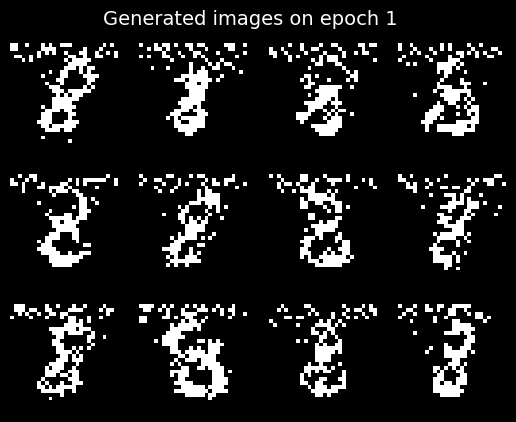

  3%|▎         | 1/30 [00:01<00:45,  1.56s/it]

Epoch: 1 - duration 1.5625245571136475s- error: 0.28080276513229246


  7%|▋         | 2/30 [00:02<00:32,  1.17s/it]

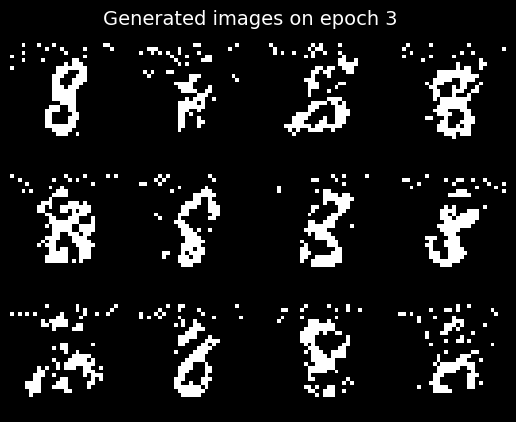

 10%|█         | 3/30 [00:04<00:40,  1.51s/it]

Epoch: 3 - duration 1.899129867553711s- error: 0.15379742030864177


 13%|█▎        | 4/30 [00:05<00:32,  1.27s/it]

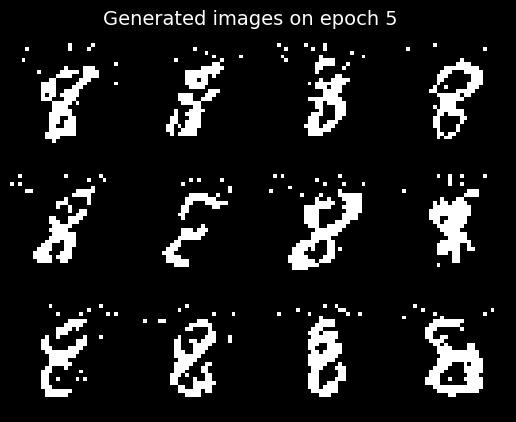

 17%|█▋        | 5/30 [00:07<00:38,  1.55s/it]

Epoch: 5 - duration 2.054607391357422s- error: 0.12628968853665434


 20%|██        | 6/30 [00:08<00:31,  1.30s/it]

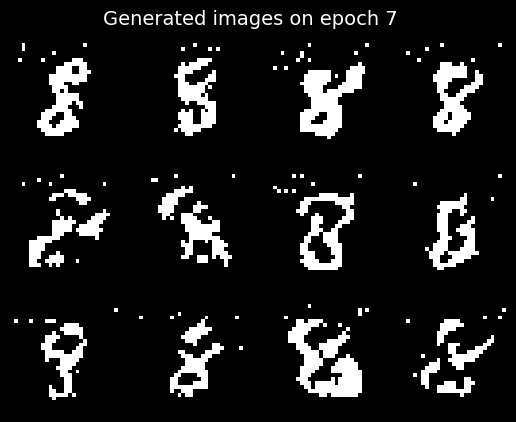

 23%|██▎       | 7/30 [00:10<00:34,  1.52s/it]

Epoch: 7 - duration 1.9687538146972656s- error: 0.11471811333752197


 27%|██▋       | 8/30 [00:10<00:28,  1.29s/it]

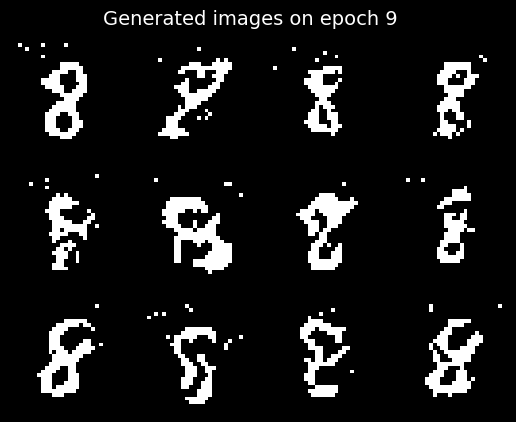

 30%|███       | 9/30 [00:12<00:29,  1.42s/it]

Epoch: 9 - duration 1.7063491344451904s- error: 0.10859202107657558


 33%|███▎      | 10/30 [00:13<00:24,  1.25s/it]

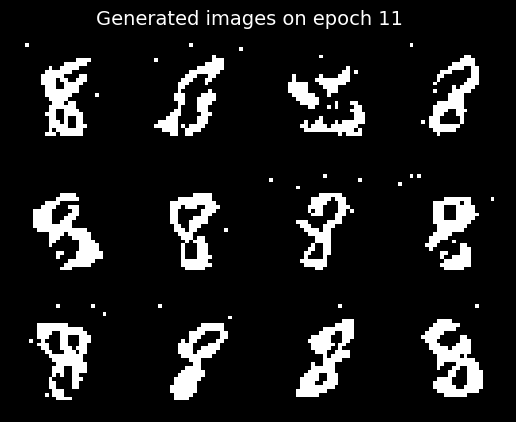

 37%|███▋      | 11/30 [00:15<00:26,  1.38s/it]

Epoch: 11 - duration 1.6831274032592773s- error: 0.10470036085209121


 40%|████      | 12/30 [00:15<00:21,  1.21s/it]

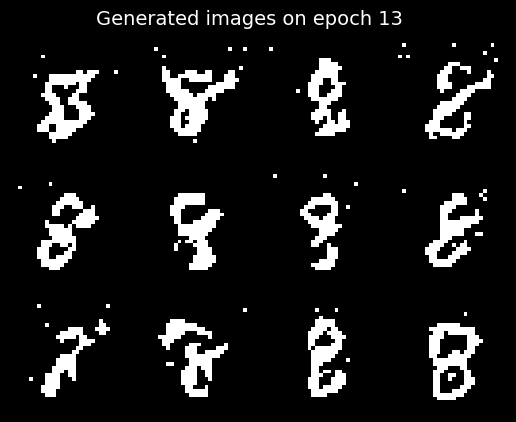

 43%|████▎     | 13/30 [00:17<00:22,  1.35s/it]

Epoch: 13 - duration 1.6602857112884521s- error: 0.102131144993979


 47%|████▋     | 14/30 [00:18<00:19,  1.20s/it]

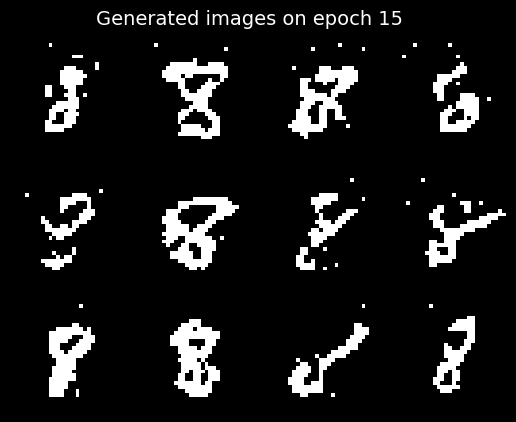

 50%|█████     | 15/30 [00:20<00:20,  1.39s/it]

Epoch: 15 - duration 1.8236289024353027s- error: 0.10033566383240015


 53%|█████▎    | 16/30 [00:21<00:17,  1.23s/it]

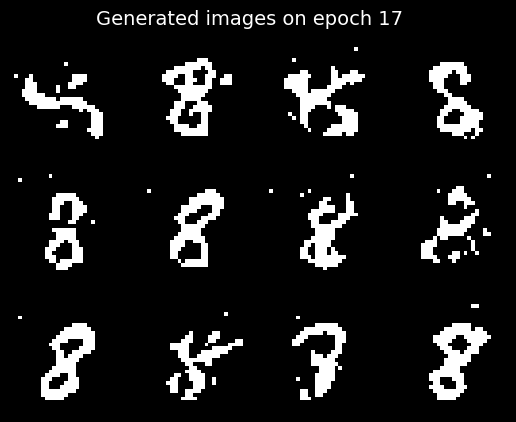

 57%|█████▋    | 17/30 [00:22<00:17,  1.37s/it]

Epoch: 17 - duration 1.6960971355438232s- error: 0.09897698437714059


 60%|██████    | 18/30 [00:23<00:14,  1.22s/it]

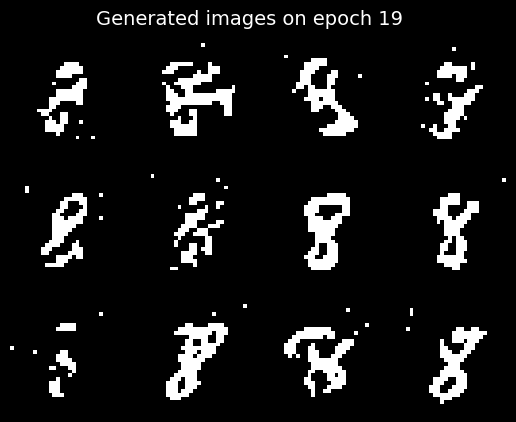

 63%|██████▎   | 19/30 [00:25<00:15,  1.43s/it]

Epoch: 19 - duration 1.9289095401763916s- error: 0.097823905799052


 67%|██████▋   | 20/30 [00:26<00:12,  1.24s/it]

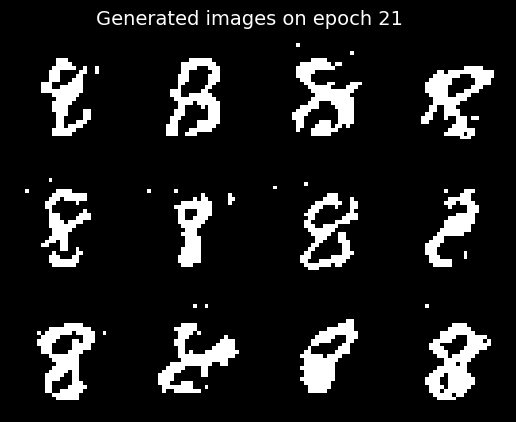

 70%|███████   | 21/30 [00:28<00:12,  1.37s/it]

Epoch: 21 - duration 1.6720707416534424s- error: 0.09700474272603574


 73%|███████▎  | 22/30 [00:29<00:09,  1.23s/it]

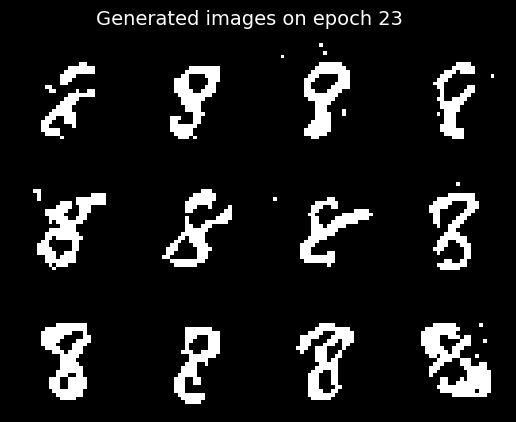

 77%|███████▋  | 23/30 [00:30<00:09,  1.36s/it]

Epoch: 23 - duration 1.6667366027832031s- error: 0.09632398665923139


 80%|████████  | 24/30 [00:31<00:07,  1.20s/it]

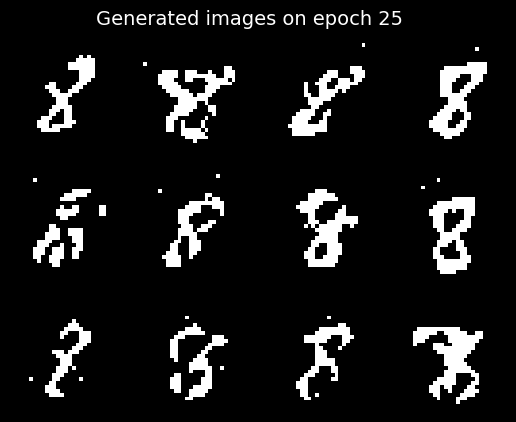

 83%|████████▎ | 25/30 [00:33<00:06,  1.33s/it]

Epoch: 25 - duration 1.632014274597168s- error: 0.09574587383995885


 87%|████████▋ | 26/30 [00:34<00:04,  1.19s/it]

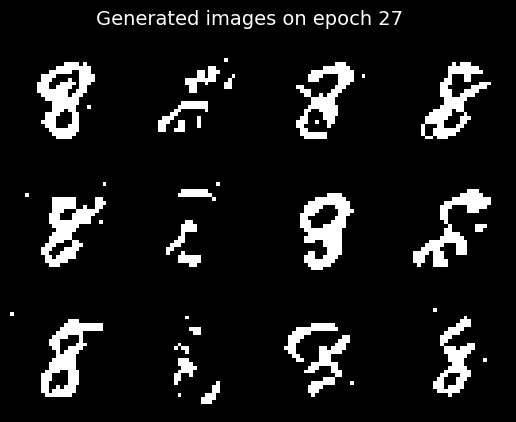

 90%|█████████ | 27/30 [00:35<00:03,  1.32s/it]

Epoch: 27 - duration 1.647143840789795s- error: 0.09534462792393954


 93%|█████████▎| 28/30 [00:36<00:02,  1.17s/it]

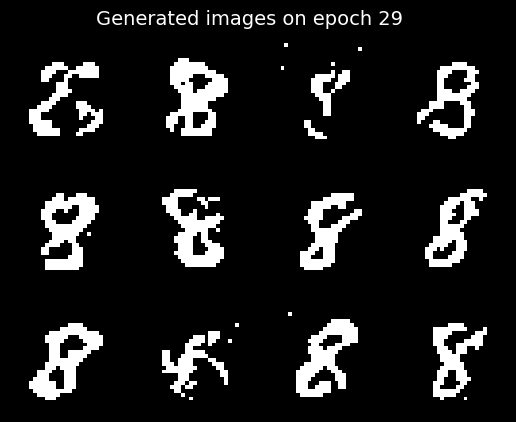

 97%|█████████▋| 29/30 [00:38<00:01,  1.33s/it]

Epoch: 29 - duration 1.6890766620635986s- error: 0.09487606406859729


100%|██████████| 30/30 [00:39<00:00,  1.30s/it]


In [87]:
trained_model = train_model(
    model=model,
    criterion=criterion,
    n_epochs=int(epochs),
    train_loader=train_dataloader,
    optim=optim_1,
    print_epoch=2
)

### Probamos el modelo generando imagenes

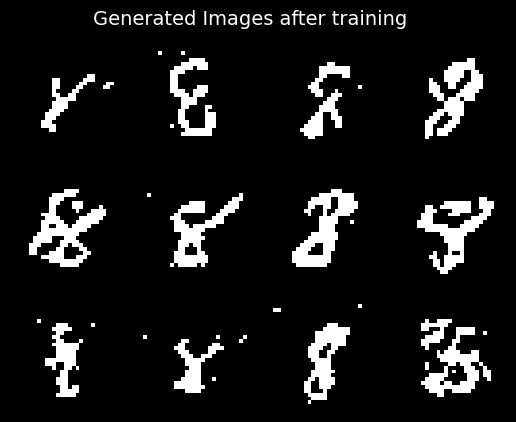

In [88]:
imgs = model.generate_x(12).cpu()
show_images(imgs, "Generated Images after training")

## Ejercicios:
1) Complete el código del perceptrón de Hinton.
2) Entrene el modelo utilizando 1 dígito.
3) Entrene el modelo utilizando al menos 3 dígitos.
4) Compare resultados. ¿Qué diferencias observas?
5) Entrene el modelo con el dataset de [FashionMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).
6) Compare y comente sobre los resultados obtenidos.

## Entrenamiento del modelo utilizando más dígitos

In [79]:
labels_2 = [3,6,9]

In [80]:
train_data_2 = datasets.MNIST(root='mnist/', train=True, transform=img_transforms, download=download_dataset)
train_data_2 = [(image, label) for image, label in train_data_2 if labels_2 and label in labels_2]

train_dataloader_2 = DataLoader(
    train_data_2, batch_size=BATCH_SIZE, shuffle=True
)


In [81]:
model_2 = HintonPerceptron(
    input_size=img_size,
    img_shape=img_shape
).to(DEVICE)

In [82]:
optim_2 = optim.Adam(model_2.parameters(), lr=0.01)

  0%|          | 0/30 [00:00<?, ?it/s]

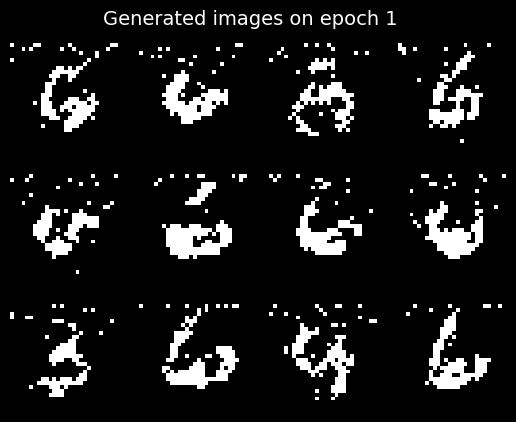

  3%|▎         | 1/30 [00:04<01:58,  4.09s/it]

Epoch: 1 - duration 4.0893940925598145s- error: 0.20041606427295833


  7%|▋         | 2/30 [00:07<01:36,  3.45s/it]

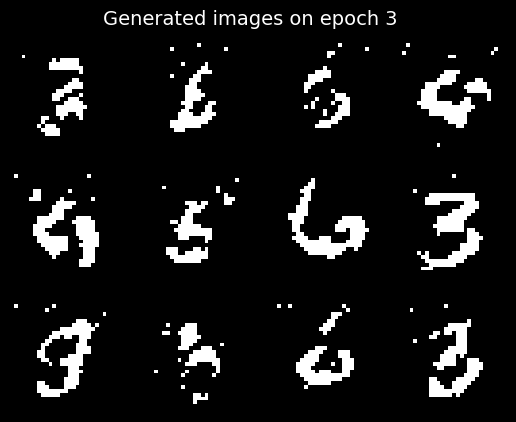

 10%|█         | 3/30 [00:10<01:32,  3.42s/it]

Epoch: 3 - duration 3.3770852088928223s- error: 0.10739587598764305


 13%|█▎        | 4/30 [00:12<01:18,  3.04s/it]

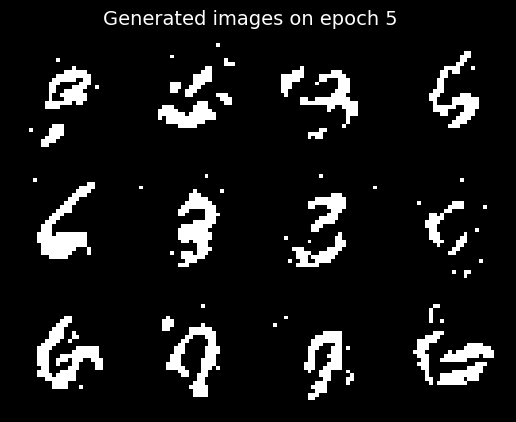

 17%|█▋        | 5/30 [00:16<01:18,  3.16s/it]

Epoch: 5 - duration 3.362762928009033s- error: 0.09771516456777322


 20%|██        | 6/30 [00:18<01:09,  2.90s/it]

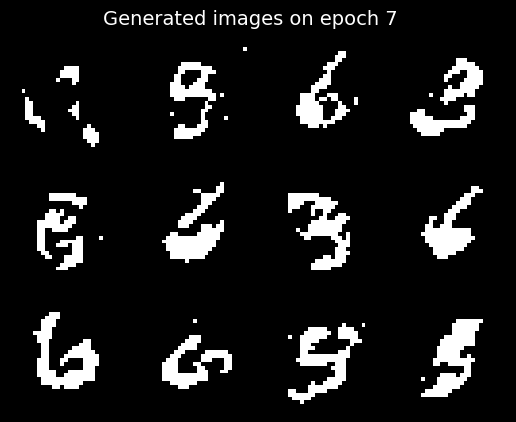

 23%|██▎       | 7/30 [00:22<01:10,  3.05s/it]

Epoch: 7 - duration 3.3624701499938965s- error: 0.09441989557223117


 27%|██▋       | 8/30 [00:24<01:02,  2.84s/it]

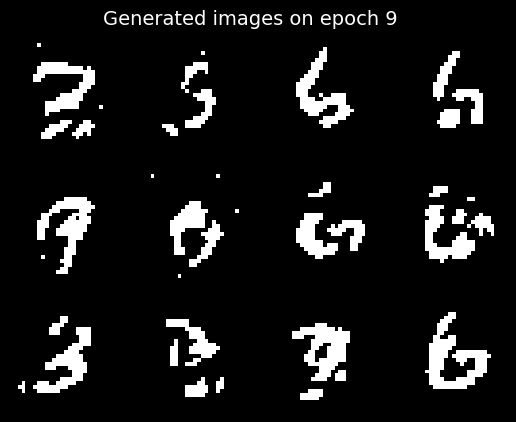

 30%|███       | 9/30 [00:27<01:03,  3.04s/it]

Epoch: 9 - duration 3.4678237438201904s- error: 0.09278849832026671


 33%|███▎      | 10/30 [00:30<00:56,  2.84s/it]

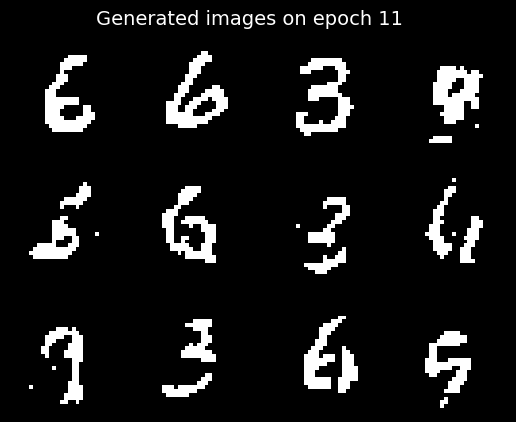

 37%|███▋      | 11/30 [00:33<00:57,  3.02s/it]

Epoch: 11 - duration 3.414080858230591s- error: 0.09192463985465943


 40%|████      | 12/30 [00:36<00:51,  2.85s/it]

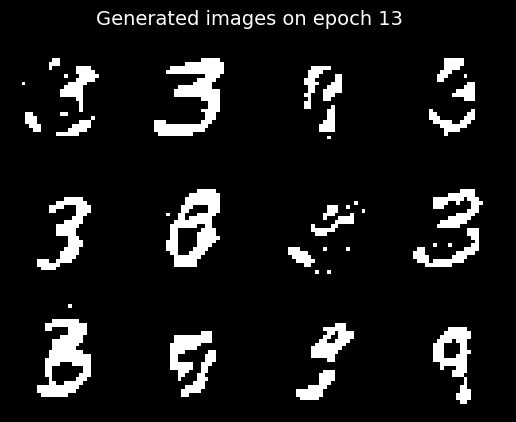

 43%|████▎     | 13/30 [00:39<00:51,  3.04s/it]

Epoch: 13 - duration 3.4799933433532715s- error: 0.09131566678167236


 47%|████▋     | 14/30 [00:42<00:45,  2.86s/it]

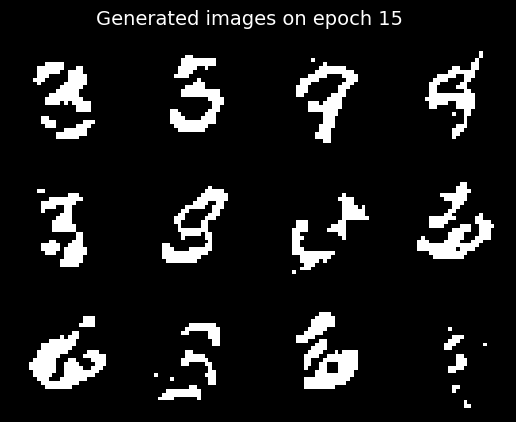

 50%|█████     | 15/30 [00:45<00:45,  3.01s/it]

Epoch: 15 - duration 3.3326590061187744s- error: 0.0909783679014402


 53%|█████▎    | 16/30 [00:47<00:39,  2.81s/it]

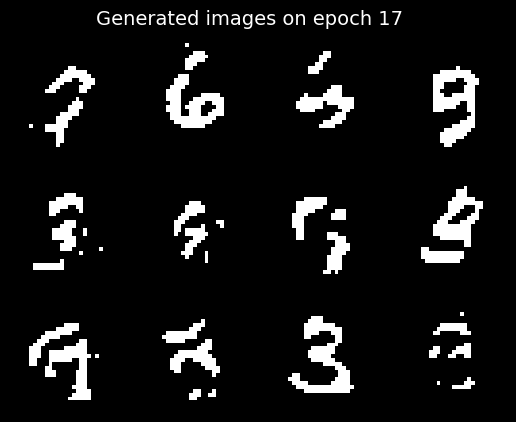

 57%|█████▋    | 17/30 [00:50<00:37,  2.92s/it]

Epoch: 17 - duration 3.1655519008636475s- error: 0.09073253031423752


 60%|██████    | 18/30 [00:53<00:32,  2.74s/it]

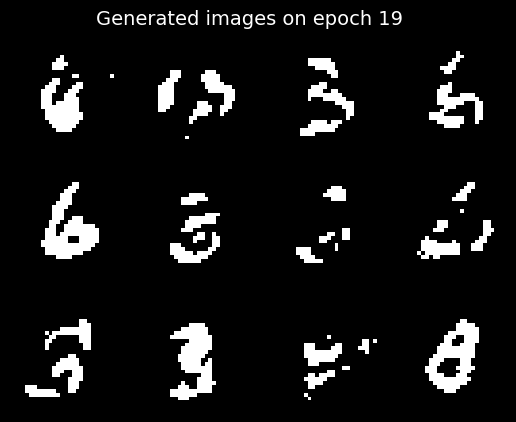

 63%|██████▎   | 19/30 [00:56<00:31,  2.91s/it]

Epoch: 19 - duration 3.2916557788848877s- error: 0.09059889054467492


 67%|██████▋   | 20/30 [00:59<00:27,  2.75s/it]

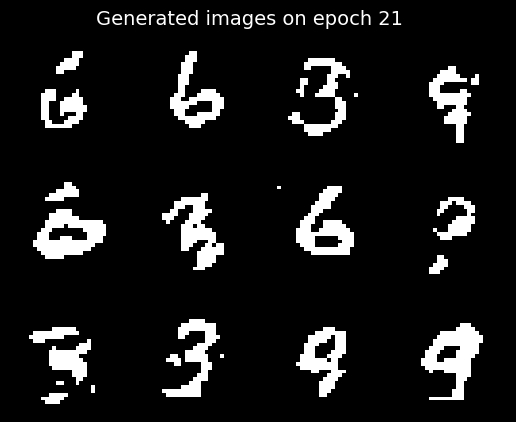

 70%|███████   | 21/30 [01:02<00:26,  2.95s/it]

Epoch: 21 - duration 3.4090540409088135s- error: 0.09046447625819673


 73%|███████▎  | 22/30 [01:04<00:22,  2.79s/it]

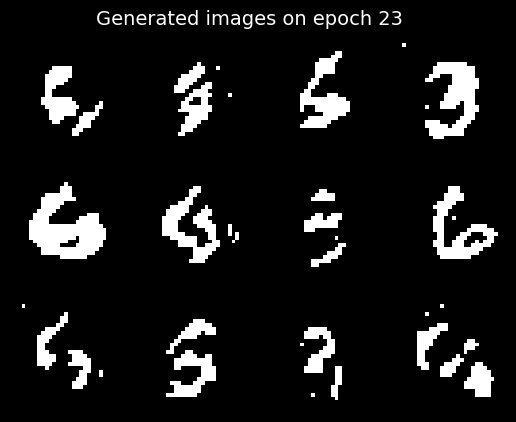

 77%|███████▋  | 23/30 [01:08<00:21,  3.02s/it]

Epoch: 23 - duration 3.575770854949951s- error: 0.0903108872420399


 80%|████████  | 24/30 [01:10<00:16,  2.82s/it]

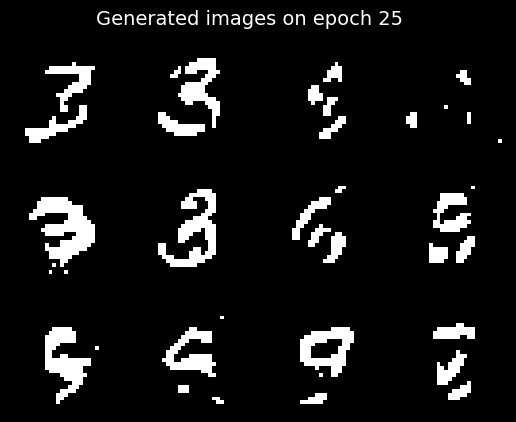

 83%|████████▎ | 25/30 [01:14<00:14,  2.95s/it]

Epoch: 25 - duration 3.251051664352417s- error: 0.09023445760104673


 87%|████████▋ | 26/30 [01:16<00:11,  2.80s/it]

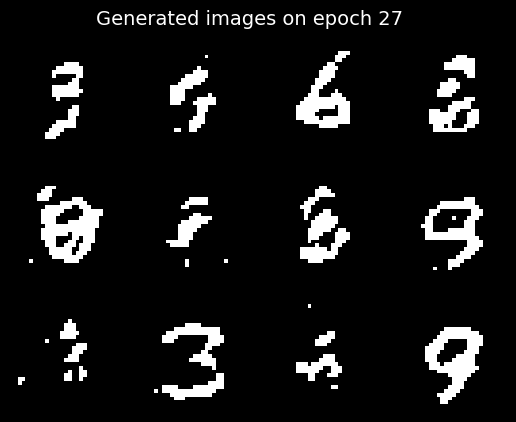

 90%|█████████ | 27/30 [01:19<00:08,  2.97s/it]

Epoch: 27 - duration 3.376943826675415s- error: 0.09014241717068862


 93%|█████████▎| 28/30 [01:22<00:05,  2.82s/it]

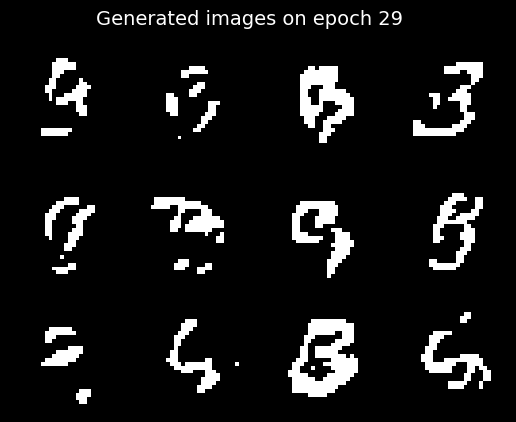

 97%|█████████▋| 29/30 [01:25<00:02,  2.94s/it]

Epoch: 29 - duration 3.213003158569336s- error: 0.09007374133835448


100%|██████████| 30/30 [01:27<00:00,  2.93s/it]


In [83]:
trained_model = train_model(
    model=model_2,
    criterion=criterion,
    n_epochs=int(epochs),
    train_loader=train_dataloader_2,
    optim=optim_2,
    print_epoch=2
)

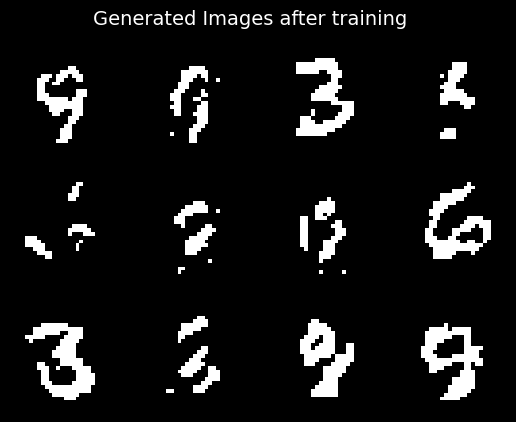

In [84]:
imgs = model_2.generate_x(12).cpu()
show_images(imgs, "Generated Images after training")